# **Colab Environment Setting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/Colab/Vision/art'
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/Colab/Vision/art'

# **Library Load**

In [ ]:
!pip install silence_tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4479 sha256=6dd46f5de9e0f9eee60f88de864f4e1eee027ba813a46d62e9362333d2d59640
  Stored in directory: /root/.cache/pip/wheels/d6/ec/29/1ed23ae577b310931b534a6da0aa3adc169deef9a8ef10bd26
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5650 sha256=91f0206b0ee269faad46d7a9bf2bc4504f7603fa4573484abb7d00a39685f23c
  Stored in directory: /root/.cache/pip/wheels/7c/a1/b1/9662c79502c353ff7e71c36f84846acd623cbcbe3f7255f5d5
Successfully built silence_tensorflow support_developer


In [ ]:
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# **fix seed** 

In [ ]:
def set_seed(seed = 6858) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.random.set_seed(seed)

    # When running on the CuDNN backend
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(6858)

Random seed set as 6858


## **parameter**

In [ ]:
INPUT_IMAGE_SIZE = None
EPOCH1 = 10
EPOCH2 = 100
BATCH_SIZE = 32
NUM_FEATURES = None
AUTO = tf.data.AUTOTUNE

# **Image Data Load**

In [ ]:
import pathlib

TRAIN_PATH = pathlib.Path(os.path.join(os.getcwd(), 'data', 'train'))
TEST_PATH = pathlib.Path(os.path.join(os.getcwd(), 'data', 'test'))

In [ ]:
train_cnt = len(list(TRAIN_PATH.glob('*/*.jpg')))
test_cnt = len(list(TEST_PATH.glob('*/*.jpg')))
print("훈련 이미지 개수 : ", train_cnt)
print("테스트 이미지 개수 : ", test_cnt)

훈련 이미지 개수 :  1698
테스트 이미지 개수 :  350


## **Class별 이미지 데이터 개수 확인**

- tran test split시 계층별로 분리를 해줘야 함.

In [ ]:
import glob
class_names = np.array(sorted([item.name for item in TRAIN_PATH.glob("*")]))
NUM_FEATURES = len(class_names)
print('NUM_FEATURES : ', NUM_FEATURES, '/', class_names)

NUM_FEATURES :  7 / ['dog' 'elephant' 'giraffe' 'guitar' 'horse' 'house' 'person']


In [ ]:
class_cnt_lst = []
for label in class_names :
    cnt = len(list((TRAIN_PATH/label).glob("*")))
    class_cnt_lst.append(cnt)
    print(f'label : {label}, ratio : {round(cnt/399, 2)}')  # max 값이 person(399 개)

label : dog, ratio : 0.82
label : elephant, ratio : 0.51
label : giraffe, ratio : 0.59
label : guitar, ratio : 0.34
label : horse, ratio : 0.38
label : house, ratio : 0.61
label : person, ratio : 1.0


<BarContainer object of 7 artists>

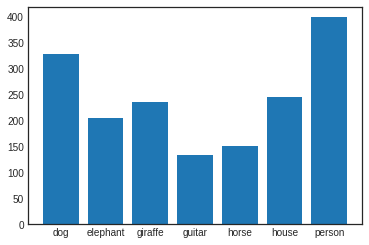

In [ ]:
fig = plt.figure()
plt.bar(x=class_names, height=class_cnt_lst)

**학습 이미지 시각화**

In [ ]:
images_show, labels_show = [], []
for i, label in enumerate(class_names) :
    for file_name in os.listdir(TRAIN_PATH/label) :
        img = cv2.imread(str(TRAIN_PATH/label/file_name))
        images_show.append(img)
        labels_show.append(label)
        break

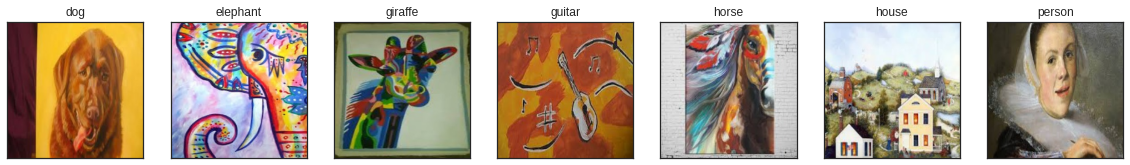

In [ ]:
#define figure
fig = plt.figure(figsize= (20, 5))

for i in range(7) : 
    num = 171 + i
    ax = fig.add_subplot(num)
    img_rgb = cv2.cvtColor(images_show[i], cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(labels_show[i])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## **전체 이미지 로드**

In [ ]:
all_images, all_labels = [], []
for i, label in enumerate(class_names) :
    for file_name in os.listdir(TRAIN_PATH/label) :
        img = cv2.imread(str(TRAIN_PATH/label/file_name))
        all_images.append(img)
        all_labels.append(i)
print(f'image : {len(all_images)}, labels : {len(all_labels)}')

image : 1698, labels : 1698


In [ ]:
INPUT_IMAGE_SIZE = all_images[0].shape[0]
print('INPUT_IMAGE_SIZE : ', INPUT_IMAGE_SIZE)

INPUT_IMAGE_SIZE :  227


# **Data Preprocessing**

- Resizing
- Rescaling for Normalization

In [ ]:
image_shape = {'resNet' : 224,
               'xception' : 299,
               'efficientNet' : 240,
               'MobileNet' : 224}

In [ ]:
resize_and_rescale_ResNet = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.Resizing(image_shape['resNet'], image_shape['resNet']),
                tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])

resize_and_rescale_Xception = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.Resizing(image_shape['xception'], image_shape['xception']),
                tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])

resize_and_rescale_EfficientNet = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.Resizing(image_shape['efficientNet'], image_shape['efficientNet']),
                tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])

# **Data Augmentation : Flip, Rotation**

- Horizontal Flip
- RadomRotation

In [ ]:
data_augmentation_ResNet = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

data_augmentation_Xception = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

data_augmentation_EfficientNet = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.01)])

# **Data Augmentation : CutMix**


In [ ]:
def sample_beta_distribution(size, concentration_0 = 0.2, concentration_1 = 0.2) :
    gamma_1_sample = tf.random.gamma(shape = [size], alpha = concentration_1)
    gamma_2_sample = tf.random.gamma(shape = [size], alpha = concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

# @tf.function
def get_box(lambda_value) :
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = INPUT_IMAGE_SIZE * cut_rat # r_width
    cut_w = tf.cast(cut_w, tf.int32)
    
    cut_h = INPUT_IMAGE_SIZE * cut_rat # r_height
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform(shape = (1,), minval = 0, maxval = INPUT_IMAGE_SIZE, dtype=tf.int32)
    cut_y = tf.random.uniform(shape = (1,), minval = 0, maxval = INPUT_IMAGE_SIZE, dtype=tf.int32)

    # boundaryx1, boundaryy1 : 왼쪽 아래 꼭지점.
    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, INPUT_IMAGE_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, INPUT_IMAGE_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, INPUT_IMAGE_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, INPUT_IMAGE_SIZE)

    target_h = bby2 - boundaryy1
    target_h += 1 if target_h == 0 else 0

    target_w = bbx2 - boundaryx1
    target_w += 1 if target_w == 0 else 0

    return boundaryx1, boundaryy1, target_h, target_w

# @tf.function
def cutmix(train_ds_one, train_ds_two) :
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two
    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` path (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE
    )

    # Get a patch form the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )

    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE
    )

    # `image1` : Bounding Box 빵구난 것, `image2` : Bounding Box만 채워져 있는 것.
    # Modify the first image by substracting the path from `image1`
    image1 = image1 - img1
    # Add the modified `image1` and `image2` together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the picel ration
    lambda_value = 1 - (target_w * target_h) / (INPUT_IMAGE_SIZE * INPUT_IMAGE_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * tf.cast(label1, tf.float32) + (1 - lambda_value) * tf.cast(label2, tf.float32)
    return image, label

In [ ]:
def cutMix_image_generator(train_dataset) :
    train_cutMix_one = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(len(train_dataset))
    train_cutMix_two = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(len(train_dataset))
    train_cutMix = tf.data.Dataset.zip((train_cutMix_one, train_cutMix_two))
    train_cutMix = train_cutMix.map(cutmix, num_parallel_calls=AUTO)
    return train_cutMix

# **configure for Performance**

In [ ]:
def configure_for_performance(ds) :
    ds = ds.shuffle(buffer_size = len(ds))
    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTO)
    return ds

# **Transfer Learning**

- EfficientNet
- Xception

In [ ]:
def build_TransferModel(resize_and_rescale, data_augmentation, base_model) :
    input = tf.keras.Input(shape = (INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, 3))
    x = resize_and_rescale(input)
    x = data_augmentation(x)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    for i in range(2) : 
        x = tf.keras.layers.Dense(int(64//(i+1)), activation = 'relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    output = tf.keras.layers.Dense(NUM_FEATURES, activation = 'softmax')(x)
    model = tf.keras.Model(inputs=input, outputs = output)

    return model

## **Xception**

In [ ]:
from tensorflow.keras.applications.xception import Xception

base_Xception = Xception(include_top = False, weights='imagenet',
                                input_tensor = None, input_shape=None,
                                pooling=None, classes=1000)

xception_model = build_TransferModel(resize_and_rescale = resize_and_rescale_Xception, 
                                         data_augmentation = data_augmentation_Xception, 
                                         base_model = base_Xception)

## **EfficientNet**

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1

base_EfficientNet = EfficientNetB1(include_top = False, weights='imagenet',
                                input_tensor = None, input_shape=None,
                                pooling=None, classes=1000)


efficientNet_model = build_TransferModel(resize_and_rescale = resize_and_rescale_EfficientNet, 
                                         data_augmentation = data_augmentation_EfficientNet, 
                                         base_model = base_EfficientNet)

# Training Model

* **Stratified Random Split for validation Robust Model**

## **Xception**

- Data Augmentation : Rotation, Flip

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5)

all_images, all_labels = np.array(all_images), np.array(all_labels)

for i, (train_index, val_index) in enumerate(sss.split(all_images, all_labels)) :
    train_images, train_labels = all_images[train_index], all_labels[train_index]
    val_images, val_labels = all_images[val_index], all_labels[val_index]

    # Make Tensorflow dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Ready for train
    train_dataset = configure_for_performance(train_dataset)
    val_dataset = configure_for_performance(val_dataset)

    # train
    lr_schedular = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=15, alpha=0.0, name=None) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedular)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15, restore_best_weights = True)]
    
    xception_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    history = xception_model.fit(train_dataset, epochs=200, 
                        validation_data = val_dataset, 
                        callbacks = callbacks)

    loss, acc = xception_model.evaluate(val_dataset)
    print(f"[{i}th Stratified Split] Xception Model Accuracy : {round(acc*100, 2)}%")

    xception_model.save_weights(f'./model/xception/{i}/xception_{i}.ckpt')

Epoch 1/200
48/48 [==============================] - 91s 1s/step - loss: 0.7887 - accuracy: 0.7677 - val_loss: 1.1397 - val_accuracy: 0.8588
Epoch 2/200
48/48 [==============================] - 48s 1s/step - loss: 0.6074 - accuracy: 0.8410 - val_loss: 0.9449 - val_accuracy: 0.8706
Epoch 3/200
48/48 [==============================] - 49s 1s/step - loss: 0.6074 - accuracy: 0.8410 - val_loss: 0.7999 - val_accuracy: 0.8765
Epoch 4/200
48/48 [==============================] - 48s 997ms/step - loss: 0.6074 - accuracy: 0.8410 - val_loss: 0.7012 - val_accuracy: 0.8706
Epoch 5/200
48/48 [==============================] - 48s 1s/step - loss: 0.6074 - accuracy: 0.8410 - val_loss: 0.6331 - val_accuracy: 0.8706
Epoch 6/200
48/48 [==============================] - 49s 1s/step - loss: 0.6074 - accuracy: 0.8410 - val_loss: 0.5886 - val_accuracy: 0.8824
Epoch 7/200
48/48 [==============================] - 48s 991ms/step - loss: 0.6074 - accuracy: 0.8410 - val_loss: 0.5606 - val_accuracy: 0.8824
Epoch 8

In [ ]:
d

## **EfficientNet**

- Data Augmentation : CutMix

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5)

# One hot Encoding Labels
all_images, all_labels = np.array(all_images), np.array(all_labels)
num = np.unique(all_labels, axis=0).shape[0]
all_labels_encoding = np.eye(num)[all_labels]

for i, (train_index, val_index) in enumerate(sss.split(all_images, all_labels_encoding)) :
    train_images, train_labels = all_images[train_index], all_labels_encoding[train_index]
    val_images, val_labels = all_images[val_index], all_labels_encoding[val_index]

    # Make Tensorflow dataset : CutMix Augmentation
    train_dataset = cutMix_image_generator((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Ready for train
    train_dataset = configure_for_performance(train_dataset)
    val_dataset = configure_for_performance(val_dataset)

    # train
    lr_schedular = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=15, alpha=0.0, name=None) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedular)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15, restore_best_weights = True)]
    METRICS = [tf.keras.metrics.Accuracy(), tf.keras.metrics.CategoricalAccuracy()]

    efficientNet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer = optimizer, metrics = [METRICS])
    history = efficientNet_model.fit(train_dataset, epochs=200, 
                        validation_data = val_dataset, 
                        callbacks = callbacks)

    predict = efficientNet_model.predict(val_images)
    acc = accuracy_score(y_true=np.argmax(val_labels, axis=1), y_pred=np.argmax(predict, axis=1))
    print(f"[{i}th Stratified Split] EfficientNet Model Accuracy : {round(acc*100, 2)}%")

    efficientNet_model.save_weights(f'./model/efficientNet/{i}/efficientNet_{i}.ckpt')

Epoch 1/200
48/48 [==============================] - 91s 497ms/step - loss: 1.6325 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4418 - val_loss: 1.9452 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.2353
Epoch 2/200
48/48 [==============================] - 19s 400ms/step - loss: 1.4008 - accuracy: 0.0000e+00 - categorical_accuracy: 0.5622 - val_loss: 1.9653 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.2353
Epoch 3/200
48/48 [==============================] - 19s 406ms/step - loss: 1.3953 - accuracy: 0.0000e+00 - categorical_accuracy: 0.5707 - val_loss: 2.0027 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.2353
Epoch 4/200
48/48 [==============================] - 19s 406ms/step - loss: 1.4082 - accuracy: 0.0000e+00 - categorical_accuracy: 0.5543 - val_loss: 2.0403 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.2353
Epoch 5/200
48/48 [==============================] - 19s 405ms/step - loss: 1.4108 - accuracy: 0.0000e+00 - categorical_accuracy

# **Emsenble Model : Logistic Regression**

* **Load Weights**

In [ ]:
xception_model.load_weights(f'./model/xception/4/xception_4.ckpt')
efficientNet_model.save_weights(f'./model/efficientNet/4/efficientNet_4.ckpt')

In [ ]:
all_images, all_labels = np.array(all_images), np.array(all_labels)
all_labels_encoding = np.eye(np.unique(all_labels, axis=0).shape[0])[all_labels]

* **Train Level1 Model**

In [ ]:
# Stratified Random Split
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.3)
for (train_index, val_index) in sss.split(all_images, all_labels) :
    # Train, Validation Set
    train_images, train_labels_x = all_images[train_index], all_labels[train_index]
    val_images, val_labels_x = all_images[val_index], all_labels[val_index]

    # Efficient Net CuMix를 고려한 label one hot encoding
    train_labels_e, val_labels_e = all_labels_encoding[train_index], all_labels_encoding[val_index]

    # Predict Model : Xecption
    train_predict_x = xception_model.predict(train_images)
    val_predict_x = xception_model.predict(val_images)

    # Predict Model : Efficient Net
    train_predict_e = efficientNet_model.predict(train_images)
    val_predict_e = efficientNet_model.predict(val_images)

16/16 [==============================] - 54s 3s/step


* **Level2 Model Logistic Regression**

In [ ]:
print('[Predict] Xception Model Shape: ', train_predict_x.shape, val_predict_x.shape)
print('[Predict] EfficientNet Model Shape: ', train_predict_e.shape, val_predict_e.shape)

[Predict] Xception Model Shape:  (1188, 7) (510, 7)
[Predict] EfficientNet Model Shape:  (1188, 7) (510, 7)
[Label] Label Shape:  (1188, 7) (510, 7)


In [ ]:
train_model2 = np.hstack((train_predict_x, train_predict_e))
val_model2 = np.hstack((val_predict_x, val_predict_e))
print('[Input] Model 2 Input Shape : ', train_model2.shape, val_model2.shape)
print('[Label] Model 2 Label Shape : ', train_labels_x.shape, val_labels_x.shape)

[Input] Model 2 Input Shape :  (1188, 14) (510, 14)
[Label] Model 2 Label Shape :  (1188,) (510,)


In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(penalty = 'l2')
logistic_regression.fit(train_model2, train_labels_x)

LogisticRegression()

In [ ]:
predict_model2 = logistic_regression.predict(val_model2)

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(val_labels_x, predict_model2)
print(f'Model2 Acc : {round(acc*100,2)}%')

Model2 Acc : 91.37%


* **Save Weights**

In [ ]:
import pickle
filename = f'./model/logistic/logistic.sav'
pickle.dump(logistic_regression, open(filename, 'wb'))

# **Predict Model**

## **Load Data**

In [ ]:
TEST_PATH = pathlib.Path(os.path.join(os.getcwd(), 'data', 'test', '0'))

test_images = []
for file_name in sorted(os.listdir(TEST_PATH)) :
    img = cv2.imread(str(TEST_PATH/file_name))
    test_images.append(img)
print(f'image : {len(test_images)}')

image : 350


In [ ]:
test_images = np.array(test_images)
print(f'[Input] : {test_images.shape}')

[Input] : (350, 227, 227, 3)


## **Predict Layer1 Model : Xception, EfficientNet**

In [ ]:
xception_model.load_weights(f'./model/xception/4/xception_4.ckpt')
efficientNet_model.load_weights(f'./model/efficientNet/2/efficientNet_2.ckpt')

In [ ]:
test_predict_x = xception_model.predict(test_images)
test_predict_e = efficientNet_model.predict(test_images)

11/11 [==============================] - 39s 4s/step


In [ ]:
print('[Predict] Xception Model Shape: ', test_predict_x.shape)
print('[Predict] EfficientNet Model Shape: ', test_predict_e.shape)

[Predict] Xception Model Shape:  (350, 7)
[Predict] EfficientNet Model Shape:  (350, 7)


## **Concatenate Prediction**

In [ ]:
test_model2 = np.hstack((test_predict_x, test_predict_e))
print('[Input] Model 2 Input Shape : ', test_model2.shape)

[Input] Model 2 Input Shape :  (350, 14)


## **Predict Layer 2 Model : Logistic Model**

In [ ]:
import pickle
logistic_regression = pickle.load(open(f'./model/logistic/logistic.sav', 'rb'))
result = logistic_regression.predict(test_model2)

In [ ]:
print(f'[Result] : {result.shape}')

[Result] : (350,)


## **Save File**

In [ ]:
result_x = np.argmax(test_predict_x, axis=1)
result_e = np.argmax(test_predict_e, axis=1)

df = pd.DataFrame({'answer value' : result})
df_x = pd.DataFrame({'answer value' : result_x})
df_e = pd.DataFrame({'answer value' : result_e})

df_x.to_csv(os.getcwd()+'/data/test_result_xception.csv')
df_e.to_csv(os.getcwd()+'/data/test_result_efficientNet.csv')
df.to_csv(os.getcwd()+'/data/test_result_ensemble.csv')

# **Result**

* **Xception Model Acurracy: 84.29%**
* **EfficientNet Model Acurracy: 65.71%**
* **Emsemble Model Acurracy: 82.86**